# Read the data 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from dslabs_functions import *

In [20]:
from pandas import read_csv, DataFrame

filename = "data/CFD.csv"
target = "CLASS"
file_tag = "CFD"
file = "CFD"
data: DataFrame = read_csv(filename, na_values="")

data.shape

(3672, 87)

# Lab01 - Data Profiling

## Data Dimensionality

In [ ]:
data.head()

In [ ]:
data.describe()

In [ ]:
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import plot_bar_chart

figure(figsize=(4, 2))
values: dict[str, int] = {"nr records": data.shape[0], "nr variables": data.shape[1]}
plot_bar_chart(
    list(values.keys()), list(values.values()), title="Nr of records vs nr variables"
)
savefig(f"images/{file_tag}_records_variables.png")
show()

In [ ]:
data.dtypes

In [ ]:
from pandas import Series, to_numeric, to_datetime


def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    for c in df.columns:
        if 2 == nr_values[c]:
            variable_types["binary"].append(c)
            df[c].astype("bool")
        else:
            try:
                to_numeric(df[c], errors="raise")
                variable_types["numeric"].append(c)
            except ValueError:
                try:
                    df[c] = to_datetime(df[c], errors="raise")
                    variable_types["date"].append(c)
                except ValueError:
                    variable_types["symbolic"].append(c)

    return variable_types

In [ ]:
variable_types: dict[str, list] = get_variable_types(data)
print(variable_types)
counts: dict[str, int] = {}
for tp in variable_types.keys():
    counts[tp] = len(variable_types[tp])

figure(figsize=(4, 2))
plot_bar_chart(
    list(counts.keys()), list(counts.values()), title="Nr of variables per type"
)
savefig(f"images/{file_tag}_variable_types.png")
show()

In [ ]:
mv: dict[str, int] = {}
for var in data.columns:
    nr: int = data[var].isna().sum()
    if nr > 0:
        mv[var] = nr

figure()
plot_bar_chart(
    list(mv.keys()),
    list(mv.values()),
    title="Nr of missing values per variable",
    xlabel="variables",
    ylabel="nr missing values",
)
savefig(f"images/{file_tag}_mv.png")
show()

### Data Granularity


In [ ]:
variable_types: dict[str, list] = get_variable_types(data)
print(variable_types)
counts: dict[str, int] = {}
for tp in variable_types.keys():
    counts[tp] = len(variable_types[tp])

figure(figsize=(4, 2))
plot_bar_chart(
    list(counts.keys()), list(counts.values()), title="Nr of variables per type"
)
savefig(f"images/{file_tag}_variable_types.png")
show()

## Data Distribution

In [ ]:
summary5: DataFrame = data.describe(include="all")
summary5

In [ ]:
variables_types: dict[str, list] = get_variable_types(data)
numeric: list[str] = variables_types["numeric"]

In [ ]:
from matplotlib.pyplot import savefig, show
from dslabs_functions import get_variable_types

variables_types: dict[str, list] = get_variable_types(data)
numeric: list[str] = variables_types["numeric"]
if [] != numeric:
    data[numeric].boxplot(rot=45)
    savefig(f"images/{file_tag}_global_boxplot.png")
    show()
else:
    print("There are no numeric variables.")

In [ ]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from dslabs_functions import define_grid, HEIGHT

if [] != numeric:
    rows: int
    cols: int
    rows, cols = define_grid(len(numeric))
    fig: Figure
    axs: ndarray
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i, j = 0, 0
    for n in range(len(numeric)):
        axs[i, j].set_title("Boxplot for %s" % numeric[n])
        axs[i, j].boxplot(data[numeric[n]].dropna().values)
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_boxplots.png")
    show()
else:
    print("There are no numeric variables.")

In [ ]:
from pandas import Series
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import plot_multibar_chart

NR_STDEV: int = 2
IQR_FACTOR: float = 1.5


def determine_outlier_thresholds_for_var(
    summary5: Series, std_based: bool = True, threshold: float = NR_STDEV
) -> tuple[float, float]:
    top: float = 0
    bottom: float = 0
    if std_based:
        std: float = threshold * summary5["std"]
        top = summary5["mean"] + std
        bottom = summary5["mean"] - std
    else:
        iqr: float = threshold * (summary5["75%"] - summary5["25%"])
        top = summary5["75%"] + iqr
        bottom = summary5["25%"] - iqr

    return top, bottom


def count_outliers(
    data: DataFrame,
    numeric: list[str],
    nrstdev: int = NR_STDEV,
    iqrfactor: float = IQR_FACTOR,
) -> dict:
    outliers_iqr: list = []
    outliers_stdev: list = []
    summary5: DataFrame = data[numeric].describe()

    for var in numeric:
        top: float
        bottom: float
        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var], std_based=True, threshold=nrstdev
        )
        outliers_stdev += [
            data[data[var] > top].count()[var] + data[data[var] < bottom].count()[var]
        ]

        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var], std_based=False, threshold=iqrfactor
        )
        outliers_iqr += [
            data[data[var] > top].count()[var] + data[data[var] < bottom].count()[var]
        ]

    return {"iqr": outliers_iqr, "stdev": outliers_stdev}


if [] != numeric:
    outliers: dict[str, int] = count_outliers(data, numeric)
    figure(figsize=(50, HEIGHT))
    plot_multibar_chart(
        numeric,
        outliers,
        title="Nr of standard outliers per variable",
        xlabel="variables",
        ylabel="nr outliers",
        percentage=False,
    )
    savefig(f"images/{file_tag}_outliers_standard.png")
    show()
else:
    print("There are no numeric variables.")

In [ ]:
from dslabs_functions import set_chart_labels

import math

HEIGHT = 4  # Height scaling for each plot
cols = 3    # Number of columns in the grid
rows = math.ceil(len(numeric) / cols)  # Calculate rows based on the number of variables

if [] != numeric:
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i: int
    j: int
    i, j = 0, 0
    for n in range(len(numeric)):
        set_chart_labels(
            axs[i, j],
            title=f"Histogram for {numeric[n]}",
            xlabel=numeric[n],
            ylabel="nr records",
        )
        axs[i, j].hist(data[numeric[n]].dropna().values, "auto")
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_histograms_numeric.png")
    show()
else:
    print("There are no numeric variables.")

In [ ]:
from numpy import log
from pandas import Series
from scipy.stats import norm, expon, lognorm
from matplotlib.axes import Axes
from dslabs_functions import plot_multiline_chart


def compute_known_distributions(x_values: list) -> dict:
    distributions = dict()
    # Gaussian
    mean, sigma = norm.fit(x_values)
    distributions["Normal(%.1f,%.2f)" % (mean, sigma)] = norm.pdf(x_values, mean, sigma)
    # Exponential
    loc, scale = expon.fit(x_values)
    distributions["Exp(%.2f)" % (1 / scale)] = expon.pdf(x_values, loc, scale)
    # LogNorm
    sigma, loc, scale = lognorm.fit(x_values)
    distributions["LogNor(%.1f,%.2f)" % (log(scale), sigma)] = lognorm.pdf(
        x_values, sigma, loc, scale
    )
    return distributions


def histogram_with_distributions(ax: Axes, series: Series, var: str):
    values: list = series.sort_values().to_list()
    ax.hist(values, 20, density=True)
    distributions: dict = compute_known_distributions(values)
    plot_multiline_chart(
        values,
        distributions,
        ax=ax,
        title="Best fit for %s" % var,
        xlabel=var,
        ylabel="",
    )


if [] != numeric:
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i, j = 0, 0
    for n in range(len(numeric)):
        histogram_with_distributions(axs[i, j], data[numeric[n]].dropna(), numeric[n])
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_histogram_numeric_distribution.png")
    show()
else:
    print("There are no numeric variables.")

In [ ]:
from dslabs_functions import plot_bar_chart

symbolic: list[str] = variables_types["symbolic"] + variables_types["binary"]
if [] != symbolic:
    rows, cols = define_grid(len(symbolic))
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i, j = 0, 0
    for n in range(len(symbolic)):
        counts: Series = data[symbolic[n]].value_counts()
        plot_bar_chart(
            counts.index.to_list(),
            counts.to_list(),
            ax=axs[i, j],
            title="Histogram for %s" % symbolic[n],
            xlabel=symbolic[n],
            ylabel="nr records",
            percentage=False,
        )
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_histograms_symbolic.png")
    show()
else:
    print("There are no symbolic variables.")

In [ ]:
target = "CLASS"

values: Series = data[target].value_counts()
print(values)

figure(figsize=(4, 2))
plot_bar_chart(
    values.index.to_list(),
    values.to_list(),
    title=f"Target distribution (target={target})",
)
savefig(f"images/{file_tag}_class_distribution.png")
show()

## Sparsity

In [ ]:
from numpy import ndarray
from pandas import read_csv, DataFrame
from matplotlib.figure import Figure
from matplotlib.pyplot import figure, subplots, savefig, show
from dslabs_functions import HEIGHT, plot_multi_scatters_chart

vars: list = data.columns.to_list()
if [] != vars:
    target = "CLASS"

    n: int = len(vars) - 1
    fig: Figure
    axs: ndarray
    fig, axs = subplots(n, n, figsize=(n * HEIGHT, n * HEIGHT), squeeze=False)
    for i in range(len(vars)):
        var1: str = vars[i]
        for j in range(i + 1, len(vars)):
            var2: str = vars[j]
            plot_multi_scatters_chart(data, var1, var2, ax=axs[i, j - 1])
    savefig(f"images/{file_tag}_sparsity_study.png")
    show()
else:
    print("Sparsity class: there are no variables.")

### The next code is the right one, I think

In [ ]:
if [] != vars:fjjffh
    target = "CLASS"

    n: int = len(vars) - 1
    fig, axs = subplots(n, n, figsize=(n * HEIGHT, n * HEIGHT), squeeze=False)
    for i in range(len(vars)):
        var1: str = vars[i]
        for j in range(i + 1, len(vars)):
            var2: str = vars[j]
            plot_multi_scatters_chart(data, var1, var2, target, ax=axs[i, j - 1])
    savefig(f"images/{file_tag}_sparsity_per_class_study.png")
    show()
else:
    print("Sparsity per class: there are no variables.")

In [ ]:
from seaborn import heatmap
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import get_variable_types

# Define your target variable
target = "CLASS"  # Replace with the actual name of your target variable

# Get numeric variable types
variables_types: dict[str, list] = get_variable_types(data)
numeric: list[str] = variables_types["numeric"]

# Add the target variable to the numeric list if it's not already included
if target not in numeric:
    numeric.append(target)

# Compute correlation matrix (including the target)
corr_mtx: DataFrame = data[numeric].corr().abs()

# Set figure size for better readability
figure(figsize=(15, 15))  # Adjust width and height as needed
heatmap(
    corr_mtx,
    xticklabels=numeric,
    yticklabels=numeric,
    fmt=".2f",           # Format numbers to 2 decimal places
    annot=True,          # Display correlation values
    cmap="Blues",
    vmin=0,
    vmax=1,
    square=True,         # Ensures cells are square
    cbar_kws={"shrink": 0.75},  # Adjust color bar size
    annot_kws={"size": 3},      # Adjust font size for annotations
)

# Save and display the heatmap
savefig(f"images/{file_tag}_correlation_analysis_with_target.png", dpi=300)  # Increase DPI for higher resolution
show()


# Lab 02 - Data Preparation

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from dslabs_functions import *

from pandas import read_csv, DataFrame

filename = "data/CFD.csv"
target = "CLASS"
file_tag = "CFD"
file = "CFD"
data: DataFrame = read_csv(filename, na_values="")

data.shape

(3672, 87)

## Methodology

In [ ]:
data.describe()

In [7]:
from pandas import read_csv, DataFrame, Series
from sklearn.preprocessing import StandardScaler

file = "CFD"
target = "CLASS"
vars: list[str] = data.columns.to_list()
print(len(vars))
data_copy = data.copy(deep=True)
target_data: Series = data_copy.pop(target)

transf: StandardScaler = StandardScaler(with_mean=True, with_std=True, copy=True).fit(
    data_copy
)
df_zscore = DataFrame(transf.transform(data_copy), index=data_copy.index)
df_zscore[target] = target_data
df_zscore.columns = vars
df_zscore.to_csv(f"data/{file}_scaled_zscore.csv", index="id")

87


In [8]:
from sklearn.preprocessing import MinMaxScaler

transf: MinMaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(data)
df_minmax = DataFrame(transf.transform(data), index=data.index)
df_minmax.columns = vars
df_minmax[target] = target_data
df_minmax.to_csv(f"data/{file}_scaled_minmax.csv", index="id")

In [9]:
# Split the data to train and test
data = df_minmax
train = data.sample(frac=0.8, random_state=42)
test = data.drop(train.index)

In [ ]:
data.describe()

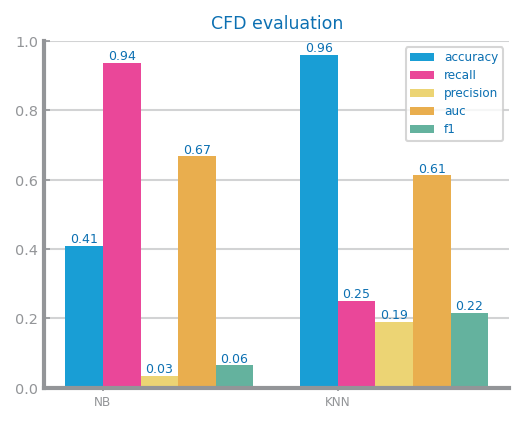

In [10]:
from numpy import ndarray
from pandas import DataFrame, read_csv
from matplotlib.pyplot import savefig, show, figure
from dslabs_functions import plot_multibar_chart, CLASS_EVAL_METRICS, run_NB, run_KNN


def evaluate_approach(
	train: DataFrame, test: DataFrame, target: str = "class", metric: str = "accuracy"
) -> dict[str, list]:
	trnY = train.pop(target).values
	trnX: ndarray = train.values
	tstY = test.pop(target).values
	tstX: ndarray = test.values
	eval: dict[str, list] = {}

	eval_NB: dict[str, float] = run_NB(trnX, trnY, tstX, tstY, metric=metric)
	eval_KNN: dict[str, float] = run_KNN(trnX, trnY, tstX, tstY, metric=metric)
	if eval_NB != {} and eval_KNN != {}:
		for met in CLASS_EVAL_METRICS:
			eval[met] = [eval_NB[met], eval_KNN[met]]
	return eval

figure()

def results(train, test, name="eval"):
	eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
	plot_multibar_chart(
		["NB", "KNN"], eval, title=f"{file_tag} evaluation", percentage=True
	)
	savefig(f"images/{file_tag}_{name}.png")
	show()

results(train, test)

## Variable encoding

#### We only have 1 binary class

#### Ask for cyclic variables in TIME

In [ ]:
from pandas import read_csv, DataFrame
from dslabs_functions import get_variable_types, encode_cyclic_variables, dummify

vars: dict[str, list] = get_variable_types(data)

yes_no: dict[str, int] = {"no": 0, "No": 0, "yes": 1, "Yes": 1}


encoding: dict[str, dict[str, int]] = {
    "CLASS": yes_no,
}
df: DataFrame = data.replace(encoding, inplace=False)
df.head()

## Missing Values Imputation

### We do not have missing values

In [ ]:
from pandas import read_csv, DataFrame
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_bar_chart

print(f"Dataset nr records={data.shape[0]}", f"nr variables={data.shape[1]}")

mv: dict[str, int] = {}
figure()
for var in data:
    nr: int = data[var].isna().sum()
    if nr > 0:
        mv[var] = nr

plot_bar_chart(
    list(mv.keys()),
    list(mv.values()),
    title="Missing values per variable",
    xlabel="variables",
    ylabel="nr missing values",
)
show()

## Outliers

In [11]:
from pandas import read_csv, DataFrame, Series
from dslabs_functions import (
    NR_STDEV,
    get_variable_types,
    determine_outlier_thresholds_for_var,
)

print(f"Original data: {data.shape}")

n_std: int = NR_STDEV
numeric_vars: list[str] = get_variable_types(data)["numeric"]


Original data: (3672, 87)


### Drop outliers

In [13]:
if numeric_vars is not None:
    df: DataFrame = data.copy(deep=True)
    summary5: DataFrame = data[numeric_vars].describe()
    for var in numeric_vars:
        top_threshold, bottom_threshold = determine_outlier_thresholds_for_var(
            summary5[var]
        )
        outliers: Series = df[(df[var] > top_threshold) | (df[var] < bottom_threshold)]
        df.drop(outliers.index, axis=0, inplace=True)
    df.to_csv(f"data/{file_tag}_drop_outliers.csv", index=True)
    print(f"Data after dropping outliers: {df.shape}")
else:
    print("There are no numeric variables")

def drop_outliers_features():
    nr_outliers = count_outliers(data, numeric_vars)


Data after dropping outliers: (632, 87)


### Replace outliers with fixed value

In [ ]:
if [] != numeric_vars:
    df: DataFrame = data.copy(deep=True)
    for var in numeric_vars:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var])
        median: float = df[var].median()
        df[var] = df[var].apply(lambda x: median if x > top or x < bottom else x)
    df.to_csv(f"data/{file_tag}_replacing_outliers.csv", index=True)
    print("Data after replacing outliers:", df.shape)
    # print(df.describe())
else:
    print("There are no numeric variables")

# Split the data to train and test
train = df.sample(frac=0.8, random_state=42)
test = df.drop(train.index)

results(train, test, "replace_outliers")

### Truncating outliers

Data after truncating outliers: (3672, 87)


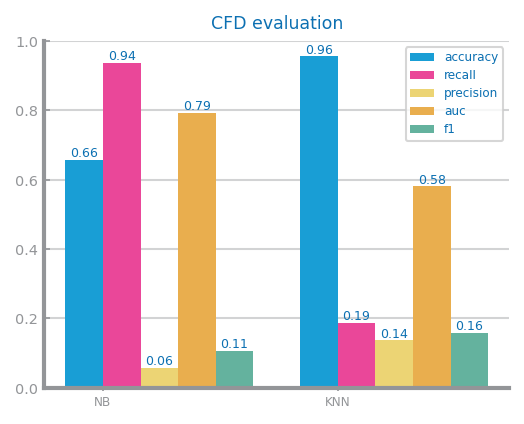

In [14]:
if [] != numeric_vars:
    df: DataFrame = data.copy(deep=True)
    for var in numeric_vars:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var])
        df[var] = df[var].apply(
            lambda x: top if x > top else bottom if x < bottom else x
        )
    df.to_csv(f"data/{file_tag}_truncate_outliers.csv", index=True)
    print("Data after truncating outliers:", df.shape)
    # print(df.describe())
else:
    print("There are no numeric variables")

# Split the data to train and test
train = df.sample(frac=0.8, random_state=42)
test = df.drop(train.index)

results(train, test, "truncate_outliers")

## Scaling

### Standard Scaler

In [ ]:
from pandas import read_csv, DataFrame, Series
from sklearn.preprocessing import StandardScaler

vars: list[str] = data.columns.to_list()

# Make a full copy of the data
data_copy = data.copy(deep=True)
print(data.shape)
target_data: Series = data_copy.pop(target)
print(data.shape)
print(data_copy.shape)

transf: StandardScaler = StandardScaler(with_mean=True, with_std=True, copy=True).fit(
    data_copy
)
df_zscore = DataFrame(transf.transform(data_copy), index=data_copy.index)
df_zscore[target] = target_data
df_zscore.columns = vars
df_zscore.to_csv(f"data/{file}_scaled_zscore.csv", index="id")

### Min-Max Scaler

In [15]:
from sklearn.preprocessing import MinMaxScaler

transf: MinMaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(data)
df_minmax = DataFrame(transf.transform(data), index=data.index)
df_minmax.columns = vars
df_minmax[target] = target_data
df_minmax.to_csv(f"data/{file}_scaled_minmax.csv", index="id")

### Results

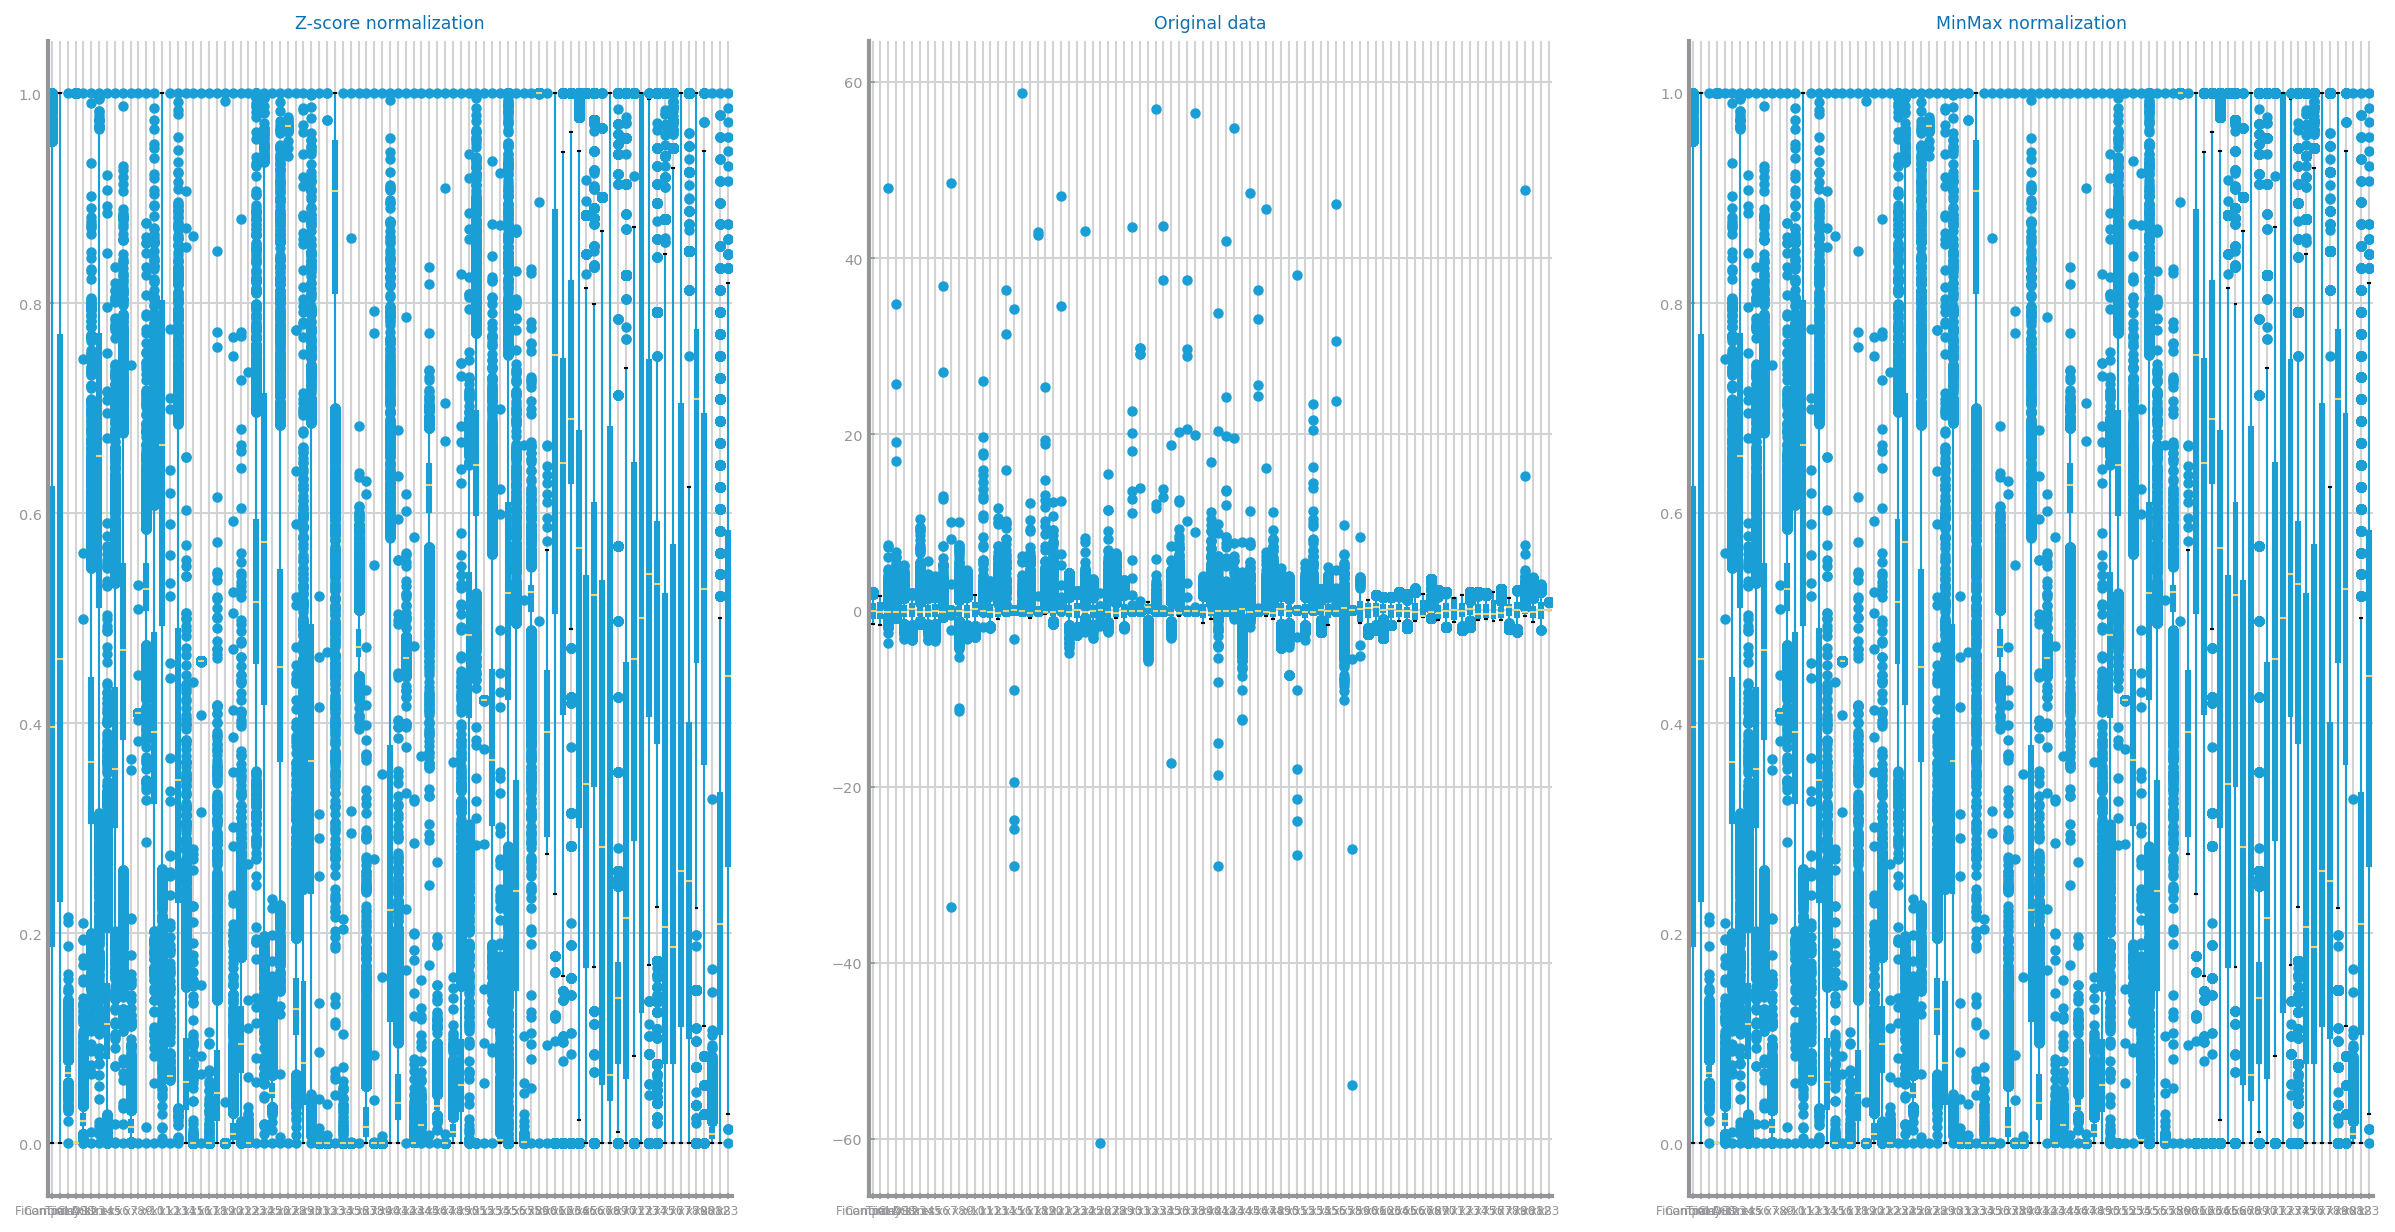

In [16]:
from matplotlib.pyplot import subplots, show

fig, axs = subplots(1, 3, figsize=(20, 10), squeeze=False)
axs[0, 1].set_title("Original data")
data.boxplot(ax=axs[0, 0])
axs[0, 0].set_title("Z-score normalization")
df_zscore.boxplot(ax=axs[0, 1])
axs[0, 2].set_title("MinMax normalization")
df_minmax.boxplot(ax=axs[0, 2])
show()

## Balancing

#### TO-DO - Adapt the code to our dataset

Minority class= 1 : 136
Majority class= 0 : 3536
Proportion: 0.04 : 1


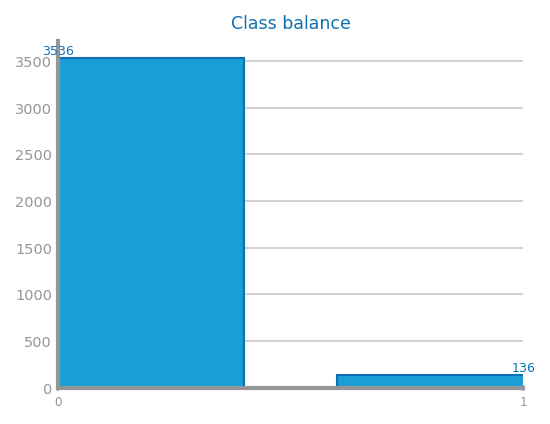

In [21]:
from pandas import read_csv, concat, DataFrame, Series
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_bar_chart

original: DataFrame = read_csv(f"data/{file}.csv", sep=",", decimal=".")

target_count: Series = original[target].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()

print("Minority class=", positive_class, ":", target_count[positive_class])
print("Majority class=", negative_class, ":", target_count[negative_class])
print(
    "Proportion:",
    round(target_count[positive_class] / target_count[negative_class], 2),
    ": 1",
)
values: dict[str, list] = {
    "Original": [target_count[positive_class], target_count[negative_class]]
}

figure()
plot_bar_chart(
    target_count.index.to_list(), target_count.to_list(), title="Class balance"
)
show()

### Splitting the target variable

In [22]:
df_positives: Series = original[original[target] == positive_class]
df_negatives: Series = original[original[target] == negative_class]

### Undersampling

In [31]:
df_neg_sample: DataFrame = DataFrame(df_negatives.sample(len(df_positives)))
df_under: DataFrame = concat([df_positives, df_neg_sample], axis=0)
df_under.to_csv(f"data/{file}_under.csv", index=False)

print("Minority class=", positive_class, ":", len(df_positives))
print("Majority class=", negative_class, ":", len(df_neg_sample))
print("Proportion:", round(len(df_positives) / len(df_neg_sample), 2), ": 1")

train = df_under.sample(frac=0.8, random_state=42)
test = df_under.drop(train.index)

results(train, test, "under")

Minority class= 1 : 136
Majority class= 0 : 136
Proportion: 1.0 : 1


ValueError: Negative values in data passed to MultinomialNB (input X)

### Oversampling

In [24]:
df_pos_sample: DataFrame = DataFrame(
    df_positives.sample(len(df_negatives), replace=True)
)
df_over: DataFrame = concat([df_pos_sample, df_negatives], axis=0)
df_over.to_csv(f"data/{file}_over.csv", index=False)

print("Minority class=", positive_class, ":", len(df_pos_sample))
print("Majority class=", negative_class, ":", len(df_negatives))
print("Proportion:", round(len(df_pos_sample) / len(df_negatives), 2), ": 1")

Minority class= 1 : 3536
Majority class= 0 : 3536
Proportion: 1.0 : 1


### SMOTE

In [26]:
from numpy import ndarray
from pandas import Series
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42

smote: SMOTE = SMOTE(sampling_strategy="minority", random_state=RANDOM_STATE)
y = original.pop(target).values
X: ndarray = original.values
smote_X, smote_y = smote.fit_resample(X, y)
df_smote: DataFrame = concat([DataFrame(smote_X), DataFrame(smote_y)], axis=1)
df_smote.columns = list(original.columns) + [target]
df_smote.to_csv(f"data/{file}_smote.csv", index=False)

smote_target_count: Series = Series(smote_y).value_counts()
print("Minority class=", positive_class, ":", smote_target_count[positive_class])
print("Majority class=", negative_class, ":", smote_target_count[negative_class])
print(
    "Proportion:",
    round(smote_target_count[positive_class] / smote_target_count[negative_class], 2),
    ": 1",
)
print(df_smote.shape)

Minority class= 1 : 3536
Majority class= 0 : 3536
Proportion: 1.0 : 1
(7072, 87)


## Discretization

### Data Preparation

In [28]:
from pandas import read_csv, DataFrame
from dslabs_functions import get_variable_types

variable_types: dict[str, list] = get_variable_types(data)
numeric_vars: list[str] = variable_types["numeric"]
symbolic_vars: list[str] = variable_types["symbolic"]
boolean_vars: list[str] = variable_types["binary"]

df_nr: DataFrame = data[numeric_vars]
df_sb: DataFrame = data[symbolic_vars]
df_bool = data[boolean_vars]

### Equal-width 

array([[<AxesSubplot:title={'center':'CLASS'}>,
        <AxesSubplot:title={'center':'Company'}>,
        <AxesSubplot:title={'center':'Time'}>,
        <AxesSubplot:title={'center':'Financial Distress'}>,
        <AxesSubplot:title={'center':'x1'}>,
        <AxesSubplot:title={'center':'x2'}>,
        <AxesSubplot:title={'center':'x3'}>,
        <AxesSubplot:title={'center':'x4'}>,
        <AxesSubplot:title={'center':'x5'}>],
       [<AxesSubplot:title={'center':'x6'}>,
        <AxesSubplot:title={'center':'x7'}>,
        <AxesSubplot:title={'center':'x8'}>,
        <AxesSubplot:title={'center':'x9'}>,
        <AxesSubplot:title={'center':'x10'}>,
        <AxesSubplot:title={'center':'x11'}>,
        <AxesSubplot:title={'center':'x12'}>,
        <AxesSubplot:title={'center':'x13'}>,
        <AxesSubplot:title={'center':'x14'}>],
       [<AxesSubplot:title={'center':'x15'}>,
        <AxesSubplot:title={'center':'x16'}>,
        <AxesSubplot:title={'center':'x17'}>,
        <AxesSubplo

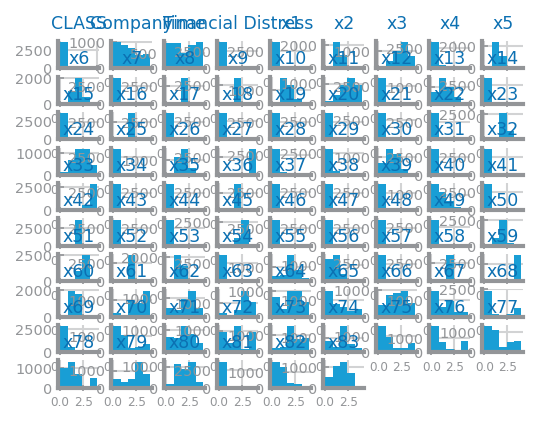

In [29]:
from sklearn.preprocessing import KBinsDiscretizer
from pandas import concat

N_BINS = 5
discretization: KBinsDiscretizer = KBinsDiscretizer(
    n_bins=N_BINS, encode="ordinal", strategy="uniform"
)
discretization.fit(df_nr)
eq_width = DataFrame(discretization.transform(df_nr), index=data.index)

df = DataFrame(df_sb, index=data.index)
df: DataFrame = concat([df, df_bool, eq_width], axis=1)
df.columns = symbolic_vars + boolean_vars + numeric_vars
df.to_csv(f"data/{file}_eq_width.csv", index=True)

df.hist(bins=N_BINS)

### Equal-frequency

array([[<AxesSubplot:title={'center':'CLASS'}>,
        <AxesSubplot:title={'center':'Company'}>,
        <AxesSubplot:title={'center':'Time'}>,
        <AxesSubplot:title={'center':'Financial Distress'}>,
        <AxesSubplot:title={'center':'x1'}>,
        <AxesSubplot:title={'center':'x2'}>,
        <AxesSubplot:title={'center':'x3'}>,
        <AxesSubplot:title={'center':'x4'}>,
        <AxesSubplot:title={'center':'x5'}>],
       [<AxesSubplot:title={'center':'x6'}>,
        <AxesSubplot:title={'center':'x7'}>,
        <AxesSubplot:title={'center':'x8'}>,
        <AxesSubplot:title={'center':'x9'}>,
        <AxesSubplot:title={'center':'x10'}>,
        <AxesSubplot:title={'center':'x11'}>,
        <AxesSubplot:title={'center':'x12'}>,
        <AxesSubplot:title={'center':'x13'}>,
        <AxesSubplot:title={'center':'x14'}>],
       [<AxesSubplot:title={'center':'x15'}>,
        <AxesSubplot:title={'center':'x16'}>,
        <AxesSubplot:title={'center':'x17'}>,
        <AxesSubplo

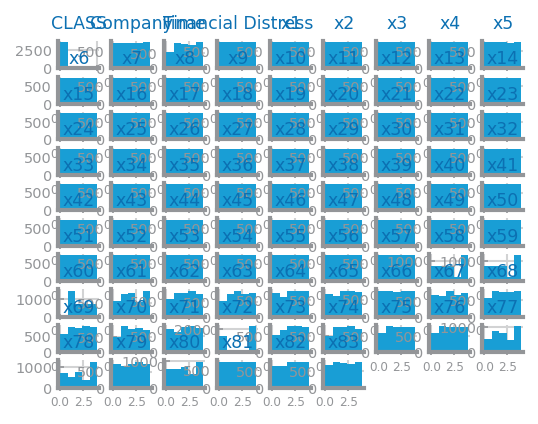

In [30]:
discretization: KBinsDiscretizer = KBinsDiscretizer(
    n_bins=N_BINS, encode="ordinal", strategy="quantile"
)
discretization.fit(df_nr)
eq_width = DataFrame(discretization.transform(df_nr), index=data.index)

df = DataFrame(df_sb, index=data.index)
df = concat([df, df_bool, eq_width], axis=1)
df.columns = symbolic_vars + boolean_vars + numeric_vars
df.to_csv(f"data/{file}_eq_frequency.csv", index=True)

df.hist(bins=N_BINS)